In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [16]:
df = pd.read_csv(r"C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\bases\data_prema.csv")

In [17]:
print(df.describe())
print(df.info())


           CODESTAB    CODMUNNASC        LOCNASC       IDADEMAE  \
count  5.235830e+05  526368.00000  526368.000000  526368.000000   
mean   2.926934e+06  261216.64844       1.016441      26.436398   
std    2.457727e+06    4355.74106       0.189859       6.713817   
min    2.400000e+01  110012.00000       1.000000      11.000000   
25%    2.344882e+06  260600.00000       1.000000      21.000000   
50%    2.430711e+06  261110.00000       1.000000      26.000000   
75%    2.711958e+06  261160.00000       1.000000      31.000000   
max    9.954279e+06  530010.00000       9.000000      99.000000   

           ESTCIVMAE         ESCMAE     CODOCUPMAE     QTDFILVIVO  \
count  522712.000000  523782.000000  507445.000000  523369.000000   
mean        2.079635       3.924396  726843.055131       1.017905   
std         1.523084       0.797589  273739.389280       1.284613   
min         1.000000       1.000000   10205.000000       0.000000   
25%         1.000000       4.000000  521110.000000 

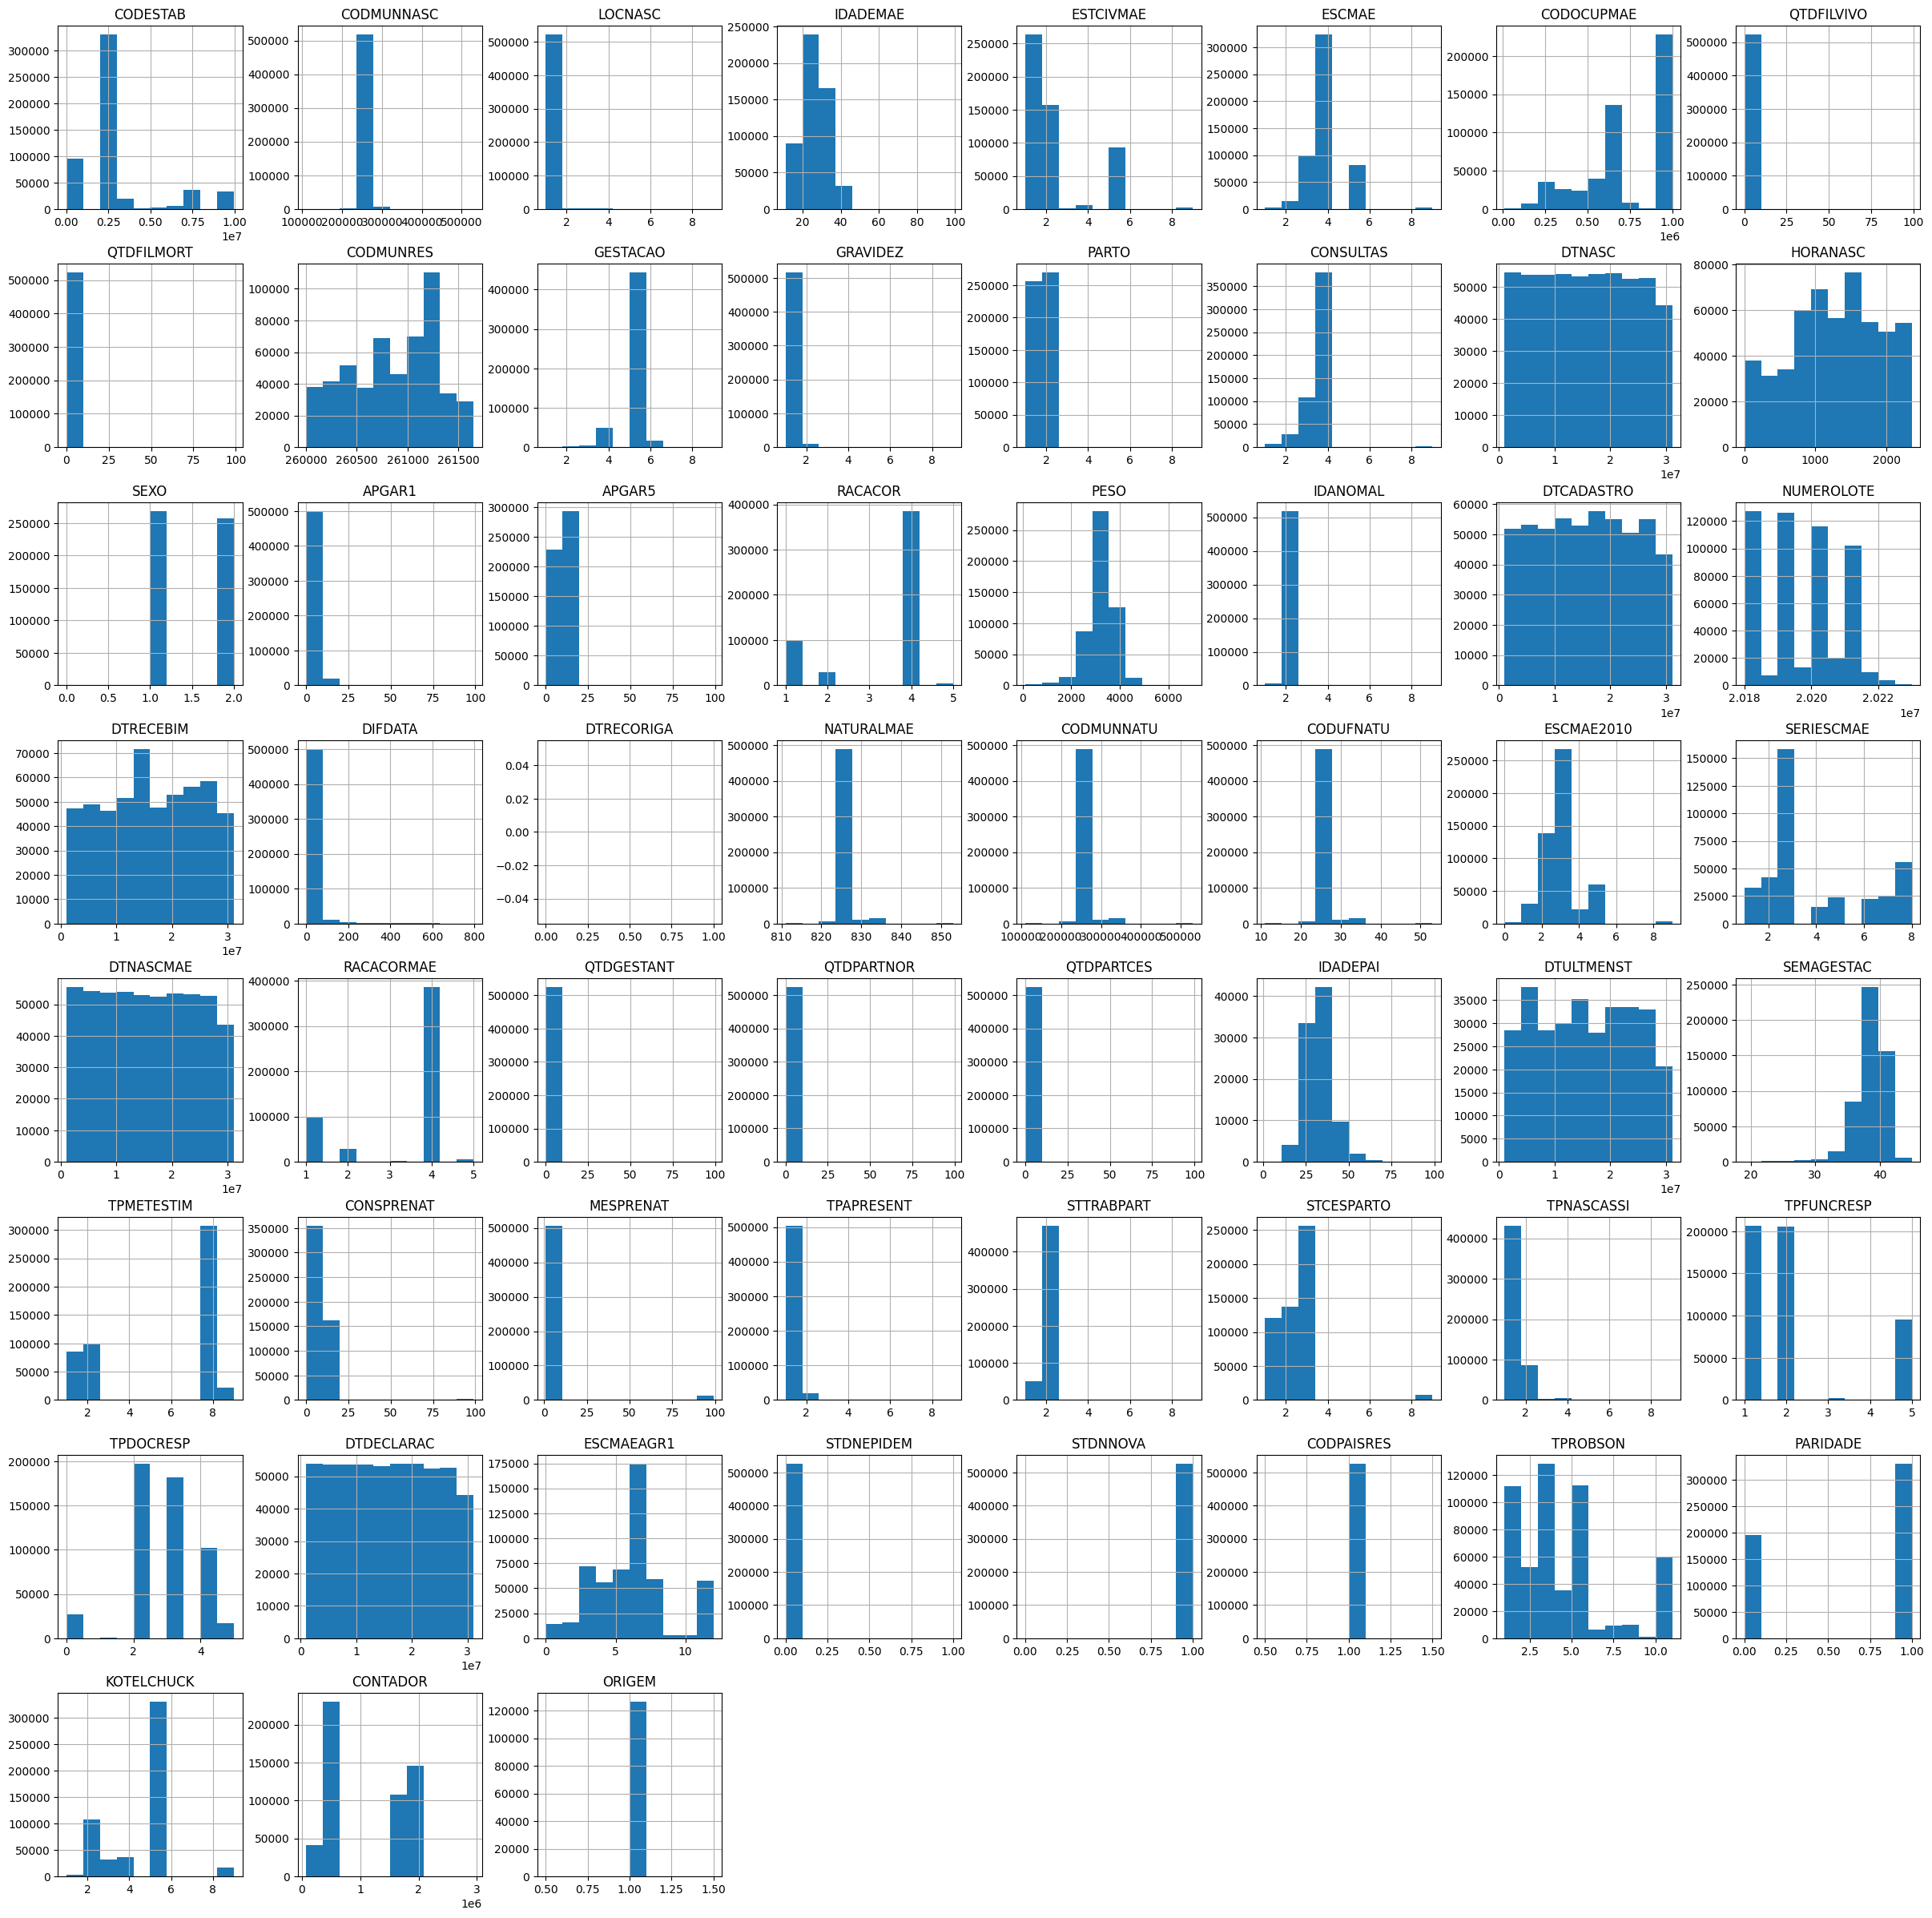

In [ ]:
df.hist(figsize=(30,30))
plt.show()


In [19]:
print(df.isnull().sum())

CODESTAB        2785
CODMUNNASC         0
LOCNASC            0
IDADEMAE           0
ESTCIVMAE       3656
               ...  
TPROBSON           0
PARIDADE           0
KOTELCHUCK         0
CONTADOR           0
ORIGEM        400157
Length: 61, dtype: int64


In [20]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

outlier_columns = []
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        outlier_columns.append(col)

print("Colunas com outliers:", outlier_columns)

Colunas com outliers: ['CODESTAB', 'CODMUNNASC', 'LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'ESCMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GESTACAO', 'GRAVIDEZ', 'PARTO', 'CONSULTAS', 'APGAR1', 'APGAR5', 'RACACOR', 'PESO', 'IDANOMAL', 'DIFDATA', 'NATURALMAE', 'CODMUNNATU', 'CODUFNATU', 'ESCMAE2010', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'IDADEPAI', 'SEMAGESTAC', 'CONSPRENAT', 'MESPRENAT', 'TPAPRESENT', 'STTRABPART', 'STCESPARTO', 'TPNASCASSI', 'TPFUNCRESP', 'TPDOCRESP', 'ESCMAEAGR1', 'STDNEPIDEM', 'STDNNOVA', 'TPROBSON', 'KOTELCHUCK']


In [21]:
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Coluna: {col}, Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Limite Inferior: {lower_bound}, Limite Superior: {upper_bound}")


Coluna: CODESTAB, Q1: 2344882.0, Q3: 2711958.0, IQR: 367076.0, Limite Inferior: 1794268.0, Limite Superior: 3262572.0
Coluna: CODMUNNASC, Q1: 260600.0, Q3: 261160.0, IQR: 560.0, Limite Inferior: 259760.0, Limite Superior: 262000.0
Coluna: LOCNASC, Q1: 1.0, Q3: 1.0, IQR: 0.0, Limite Inferior: 1.0, Limite Superior: 1.0
Coluna: IDADEMAE, Q1: 21.0, Q3: 31.0, IQR: 10.0, Limite Inferior: 6.0, Limite Superior: 46.0
Coluna: ESTCIVMAE, Q1: 1.0, Q3: 2.0, IQR: 1.0, Limite Inferior: -0.5, Limite Superior: 3.5
Coluna: ESCMAE, Q1: 4.0, Q3: 4.0, IQR: 0.0, Limite Inferior: 4.0, Limite Superior: 4.0
Coluna: CODOCUPMAE, Q1: 521110.0, Q3: 999992.0, IQR: 478882.0, Limite Inferior: -197213.0, Limite Superior: 1718315.0
Coluna: QTDFILVIVO, Q1: 0.0, Q3: 1.0, IQR: 1.0, Limite Inferior: -1.5, Limite Superior: 2.5
Coluna: QTDFILMORT, Q1: 0.0, Q3: 0.0, IQR: 0.0, Limite Inferior: 0.0, Limite Superior: 0.0
Coluna: CODMUNRES, Q1: 260500.0, Q3: 261160.0, IQR: 660.0, Limite Inferior: 259510.0, Limite Superior: 262150

In [ ]:
print(df.select_dtypes(include=['object']).columns)

Index(['CODANOMAL', 'VERSAOSIST'], dtype='object')


In [25]:
df = pd.get_dummies(df, columns=['CODANOMAL', 'VERSAOSIST'])

In [27]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print(df.head())

c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


   CODESTAB  CODMUNNASC   LOCNASC  IDADEMAE  ESTCIVMAE    ESCMAE  CODOCUPMAE  \
0  1.772584  -25.515005 -0.086596  0.381840  -0.708848  6.363692         NaN   
1  2.490021  -25.501230 -0.086596  1.573414  -0.052285  0.094791    0.997844   
2 -0.094654   -9.363892 -0.086596 -1.554467   4.543657  0.094791   -0.386638   
3 -0.228631   -9.283538 -0.086596 -0.660787   1.917404  0.094791   -0.386638   
4 -0.228675   -9.283538 -0.086596  0.977627  -0.052285  1.348571         NaN   

   QTDFILVIVO  QTDFILMORT  CODMUNRES  ...  CODANOMAL_Q915  CODANOMAL_Q917  \
0   -0.013938    1.220971  -1.688498  ...           False           False   
1   -0.792384   -0.399514  -0.151005  ...           False           False   
2   -0.792384   -0.399514  -1.759459  ...           False           False   
3   -0.792384   -0.399514   0.948895  ...           False           False   
4   -0.013938   -0.399514  -1.972343  ...           False           False   

   CODANOMAL_Q929  CODANOMAL_Q969  CODANOMAL_Q999  VERSA

In [ ]:
normalizer = MinMaxScaler()
df[numeric_columns] = normalizer.fit_transform(df[numeric_columns])
print(df.head())

c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


   CODESTAB  CODMUNNASC  LOCNASC  IDADEMAE  ESTCIVMAE  ESCMAE  CODOCUPMAE  \
0  0.731691    0.095400      0.0  0.204545      0.000   1.000         NaN   
1  0.908827    0.095543      0.0  0.295455      0.125   0.375    0.999998   
2  0.270666    0.262901      0.0  0.056818      1.000   0.375    0.617101   
3  0.237587    0.263735      0.0  0.125000      0.500   0.375    0.617101   
4  0.237576    0.263735      0.0  0.250000      0.125   0.500         NaN   

   QTDFILVIVO  QTDFILMORT  CODMUNRES  ...  CODANOMAL_Q915  CODANOMAL_Q917  \
0    0.010101    0.010101   0.084848  ...           False           False   
1    0.000000    0.000000   0.478788  ...           False           False   
2    0.000000    0.000000   0.066667  ...           False           False   
3    0.000000    0.000000   0.760606  ...           False           False   
4    0.010101    0.000000   0.012121  ...           False           False   

   CODANOMAL_Q929  CODANOMAL_Q969  CODANOMAL_Q999  VERSAOSIST_2.2.03  \
0 

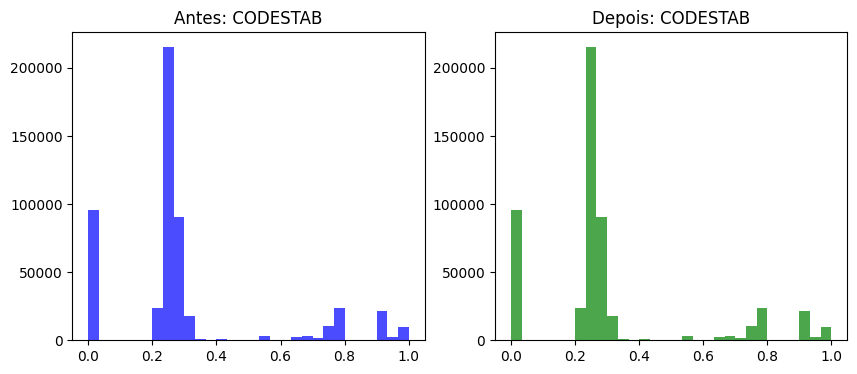

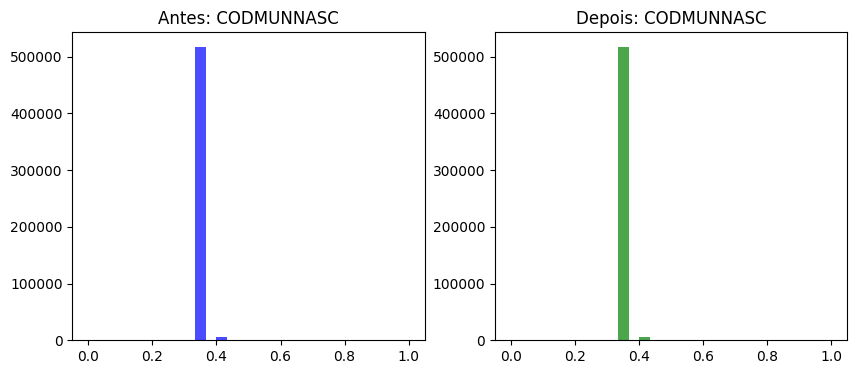

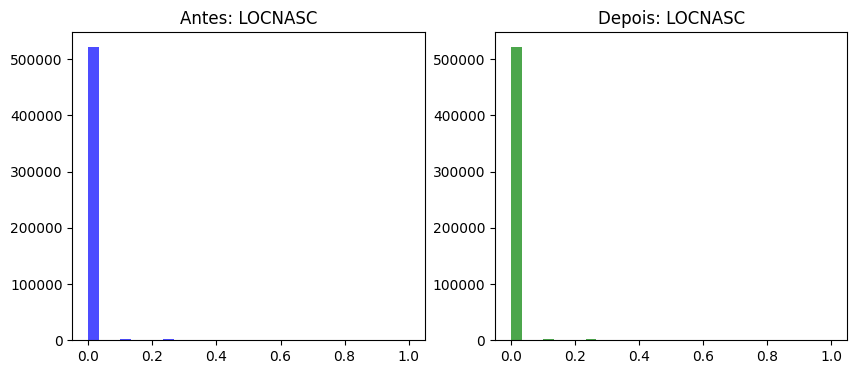

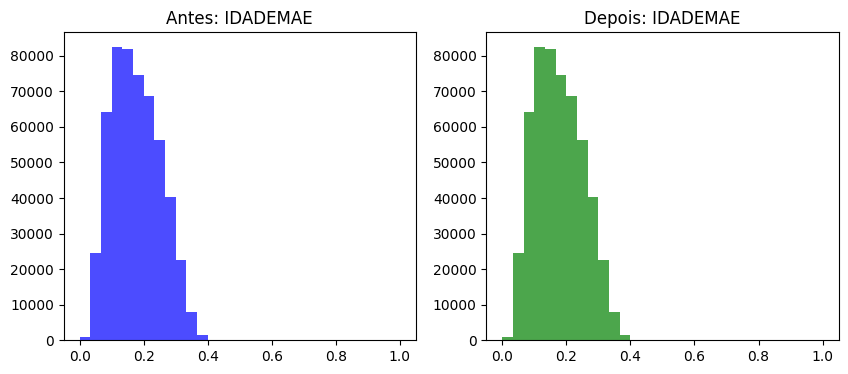

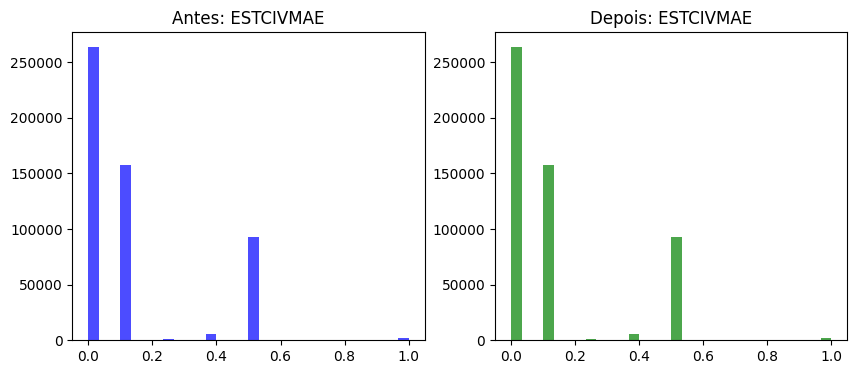

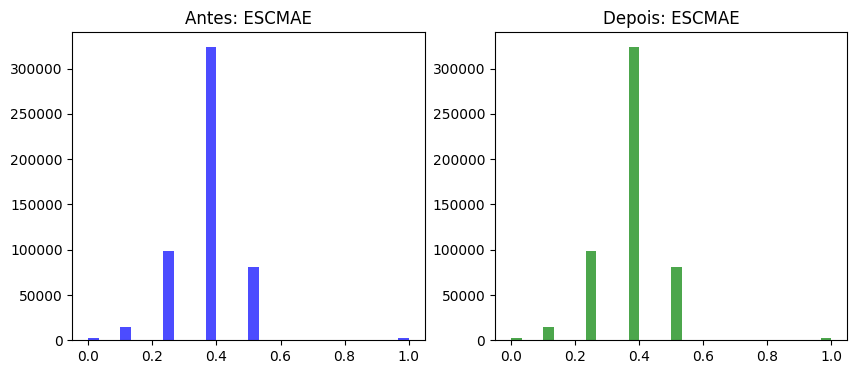

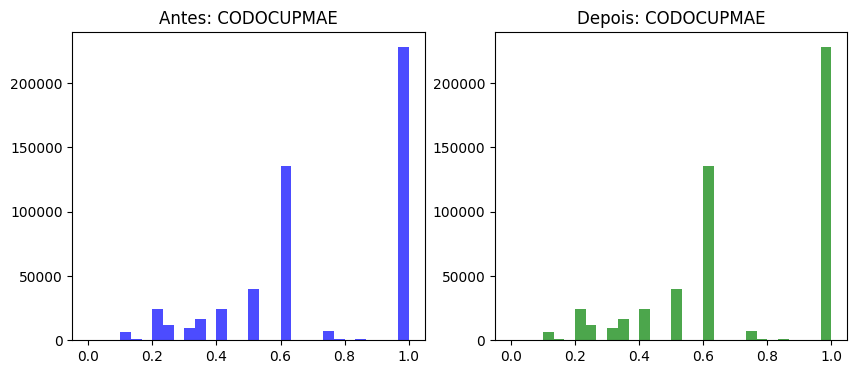

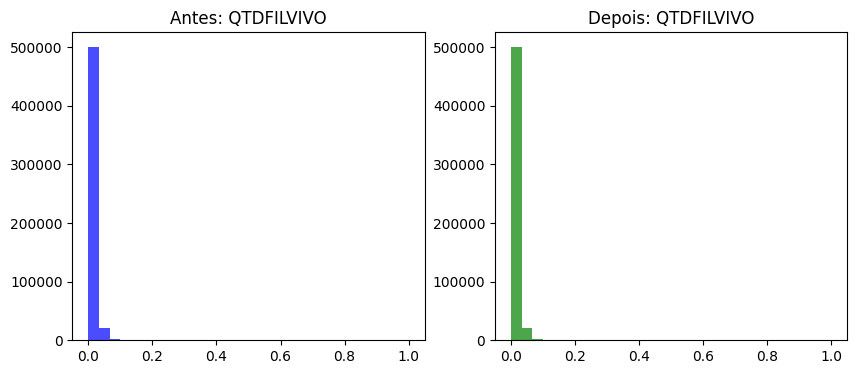

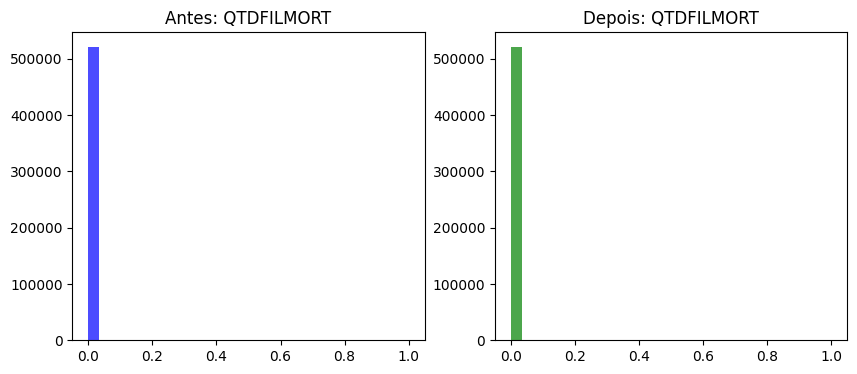

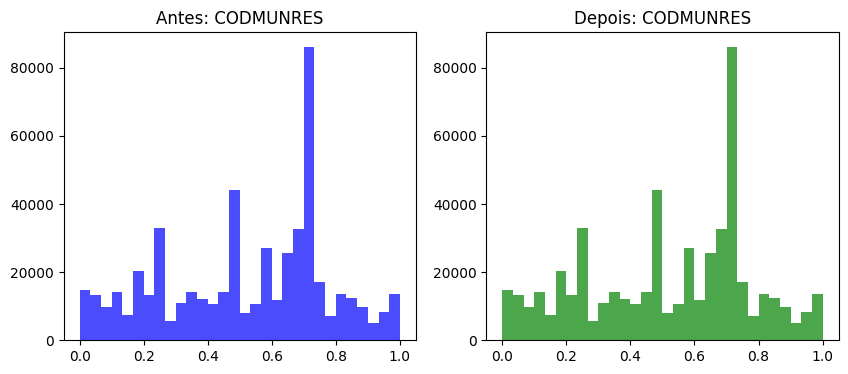

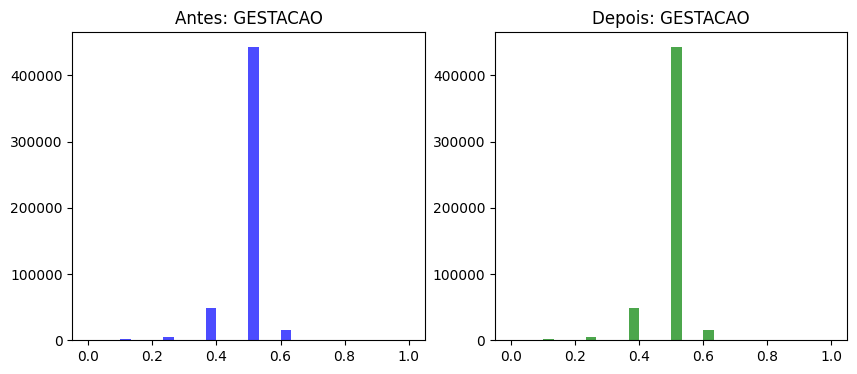

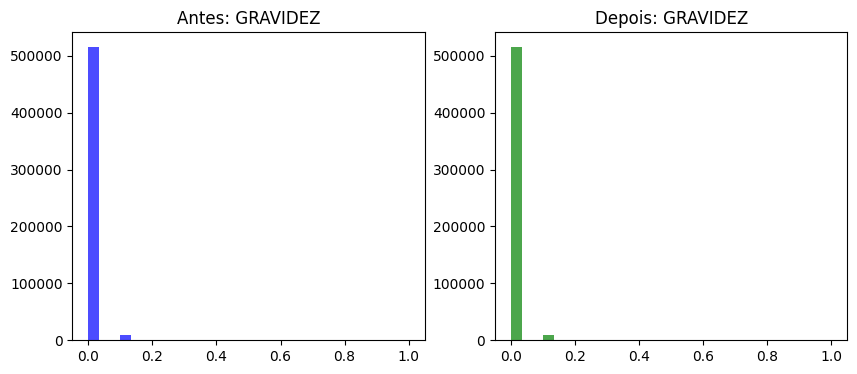

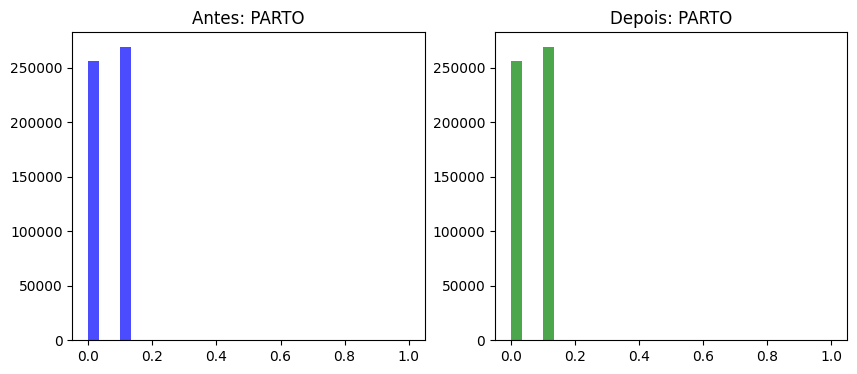

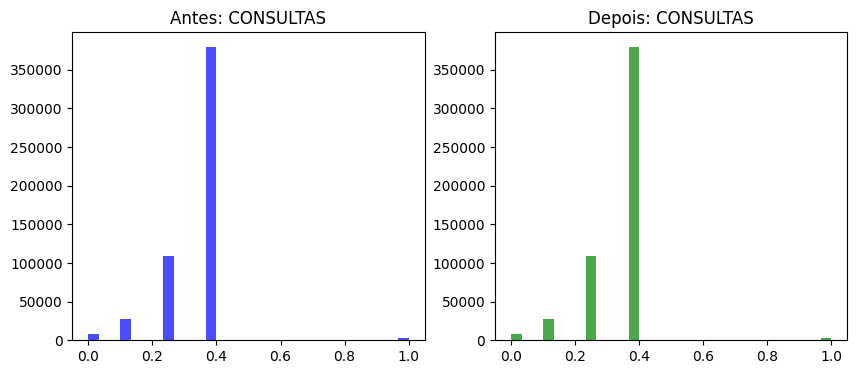

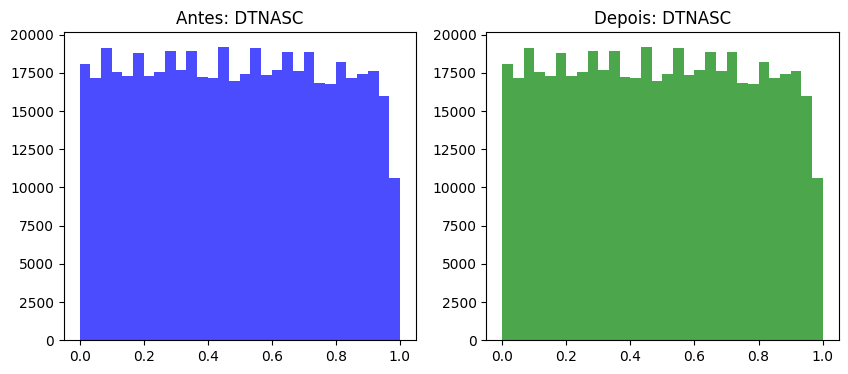

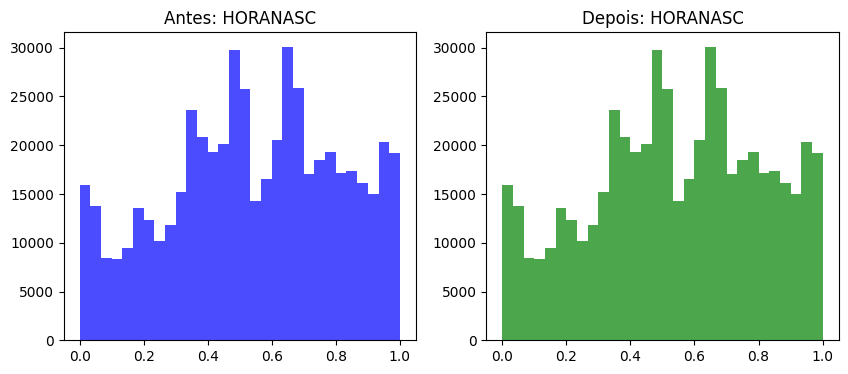

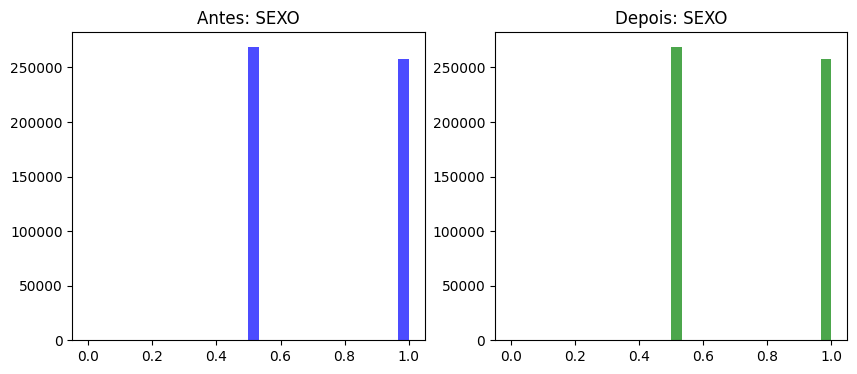

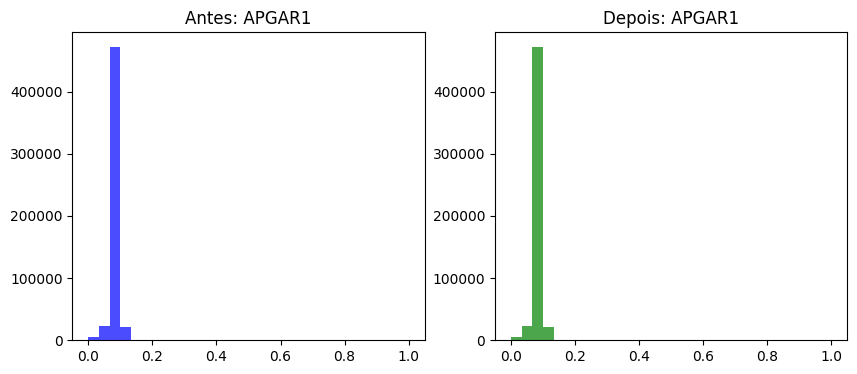

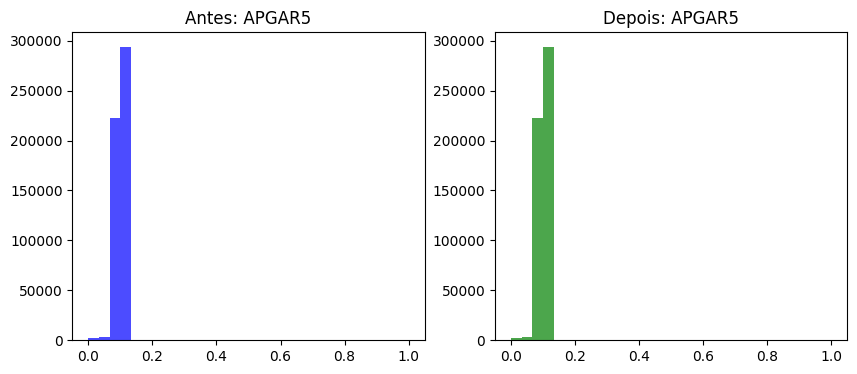

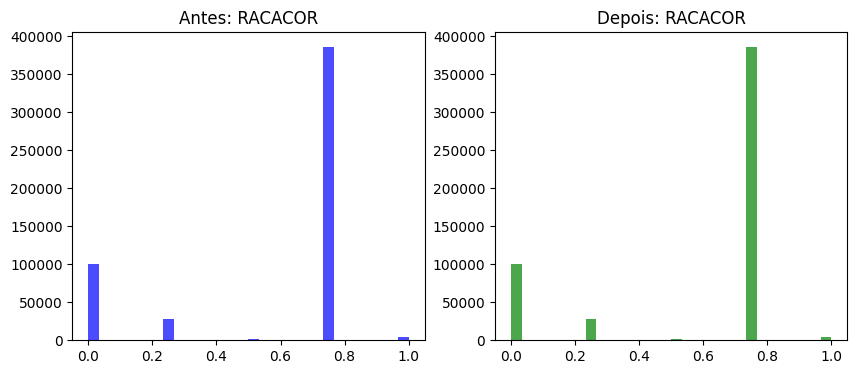

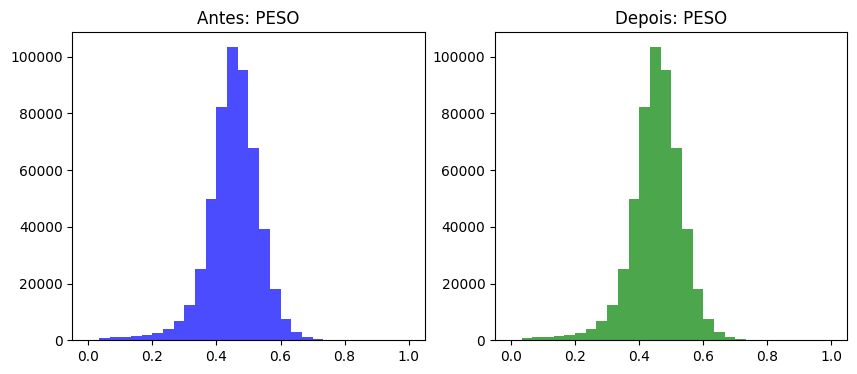

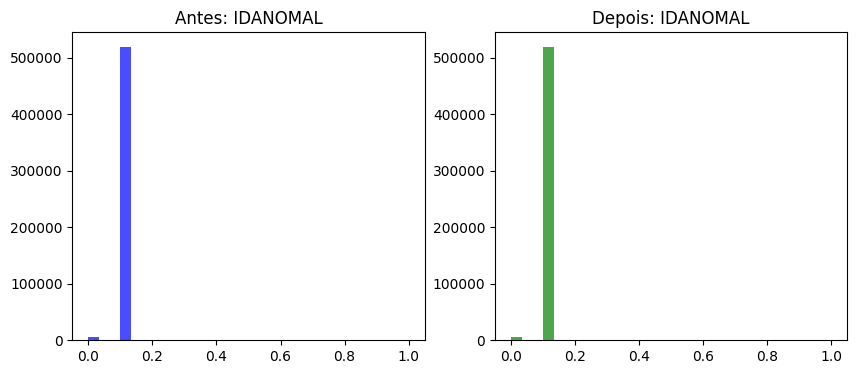

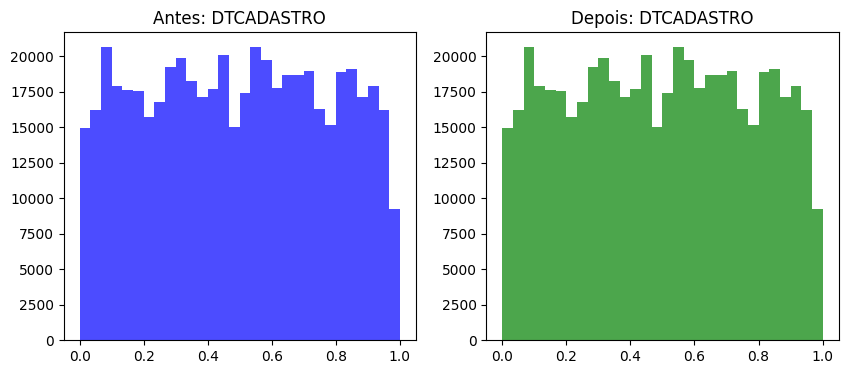

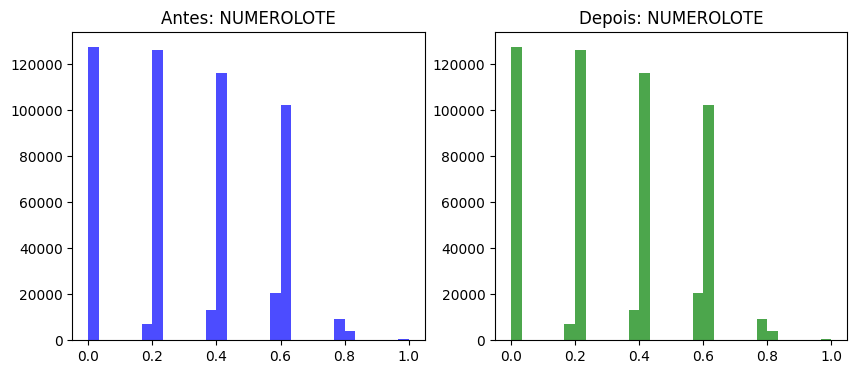

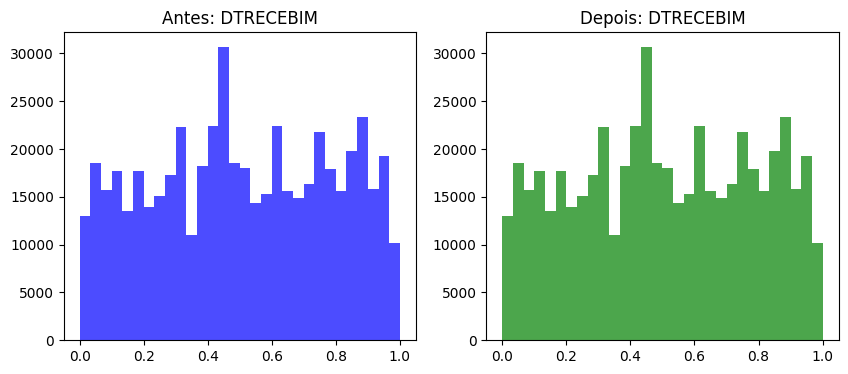

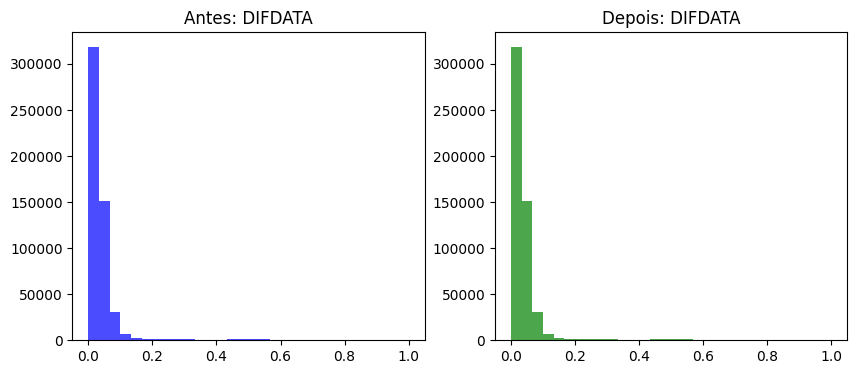

c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:6834: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\annab\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:6835: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

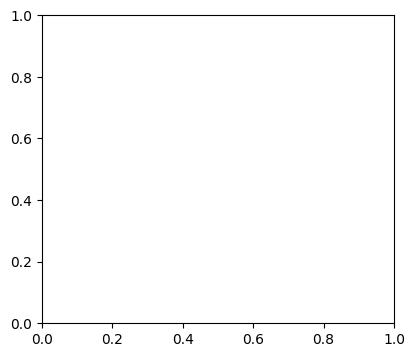

In [32]:
for col in numeric_columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=30, color='blue', alpha=0.7)
    plt.title(f'Antes: {col}')
    
    plt.subplot(1, 2, 2)
    plt.hist(df[col], bins=30, color='green', alpha=0.7)
    plt.title(f'Depois: {col}')
    
    plt.show()


In [34]:

from sklearn.model_selection import train_test_split

X = df.drop(columns=['GESTACAO'])
y = df['GESTACAO']                

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (368457, 1007)
X_test shape: (157911, 1007)
y_train shape: (368457,)
y_test shape: (157911,)


In [ ]:
caminho_pasta = r'C:\Users\SeuUsuario\RECPAD\Processamento'
arquivo_csv = f'{caminho_pasta}\processamento_final.csv'
df.to_csv('base_processada', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\annab\AppData\Local\Temp\ipykernel_11760\955990001.py:2: SyntaxWarning: invalid escape sequence '\p'
  arquivo_csv = f'{caminho_pasta}\processamento_final.csv'
